<font size = 5><b>CS584 Assignment II : Generative Learning</b></font>

### Gaussian Discriminant Analysis

In [76]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mpl
from sklearn.cross_validation import KFold 
from collections import defaultdict
from sys import float_info
from sys import maxint
import math as math
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import Binarizer 
from random import randint
import random as rd
from scipy.special import comb

In [29]:
def plot_data(X_data,Y_data,plot_type='bo',X_name='X-axis',Y_name='Y-axis',multi_plot='N',X2_data='N',Y2_data='N',plot2_type='N'):
    '''Plot data on to screen'''
    fig = mpl.figure()
    ax = fig.add_subplot(111)
    ax.set_xlabel(X_name)    
    ax.set_ylabel(Y_name)           
    ax.plot(X_data,Y_data,plot_type)
    if multi_plot == 'Y':        
        ax.plot(X2_data,Y2_data,plot2_type)
    mpl.show()

In [30]:
def get_features_labels(data_matrix):
    '''Segregate the features and labels , and return them
    '''
    return data_matrix[:,:len(data_matrix[0])-1],data_matrix[:,len(data_matrix[0])-1:]

In [4]:
def mu_j(data_matrix):
    '''
    Computes the mean vector for every different class in the data matrix
    '''    
    mu_j = defaultdict(lambda : np.zeros(len(data_matrix[0])-1))    
    j_count = defaultdict(lambda : 0)
    
    for row in data_matrix:
        
        lbl      = row[len(row)-1]
        feat_vec = row[0:len(row)-1]
        
        mu_j[lbl] += feat_vec
        
        j_count[lbl] += 1
    
    for lbl in mu_j.keys():
        mu_j[lbl] /= j_count[lbl]
    
    return mu_j,j_count

In [5]:
def get_params(data_matrix):
    '''
    Computes the Co-variance matrix all the different class labels in the training dataset.    
    '''
    j_SigmaJ,j_Mj = mu_j(data_matrix)
    
    feature_matrix,labels= get_features_labels(data_matrix)
    
    no_of_features = len(feature_matrix[0])
    
    cov_j = defaultdict(lambda : np.zeros((no_of_features,no_of_features)))
    
    lbl_and_cnt = defaultdict(lambda : 0)
    
    for _id,label in enumerate(labels):        
        X_minus_mu_j = feature_matrix[_id] - j_SigmaJ[label[0]]
        cov_j[label[0]] += np.outer(X_minus_mu_j,np.transpose(X_minus_mu_j)) 
    
    for j in cov_j.iterkeys():
        cov_j[j] /= float(j_Mj[j])
    
    return {'cov' : cov_j, 'mean' : j_SigmaJ, 'count' : j_Mj}

In [6]:
def membership_j(j,mu_j,cov_j,X,alpha_j):
    '''
    Computes the the membership value for class j of a given feature vector X.
    '''
    g_of_x = 0.0
    
    det = np.linalg.det(cov_j)    
    det = math.pow(det,0.5)
    
    g_of_x += (-1.0 * math.log(det))    
    g_of_x += math.log(alpha_j)
    
    x_minus_j = X - mu_j
    
    trans_x = np.transpose(x_minus_j)
    cov_inv = np.linalg.inv(cov_j)
    

    g_of_x += (-0.5 * np.dot(np.dot(x_minus_j,cov_inv),trans_x))
    
    return g_of_x
    

In [52]:
def replace_zero(x):
    '''
    To avoid divide by zero errors.
    '''
    if x == 0 :
        return 1
    else:
        return x

In [53]:
def evaluate_performance(conf_matrix):
    '''
    For a confusion matrix, compute accuracy, precison, recall and F-Measure.
    '''    
    measure_and_value = defaultdict(lambda : defaultdict(lambda : 0.0) )
    
    #Accuracy
    measure_and_value['acc'] = float(conf_matrix.trace())/replace_zero(np.sum(conf_matrix))
    
    #Precision
    for r_num,row in enumerate(conf_matrix):
        measure_and_value['prec'][r_num+1] = conf_matrix[r_num,r_num] / replace_zero(sum(row))
    
    
    conf_mat_trans = np.transpose(conf_matrix)
    
    #Recall
    for r_num,row in enumerate(conf_mat_trans):
        measure_and_value['rec'][r_num+1] = conf_mat_trans[r_num,r_num] / replace_zero(sum(row))
    
    #F-Measure
    for j in measure_and_value['rec'].keys():
        nr = 2 * measure_and_value['prec'][j] * measure_and_value['rec'][j]
        dr = measure_and_value['prec'][j] + measure_and_value['rec'][j]
        
        measure_and_value['F-Measure'][j] = float(nr) / replace_zero(dr)
            
    return measure_and_value

In [9]:
def K_fold(K,data_matrix,PR_Curve='N',tow=1):
    '''
    Perform K-Fold cross validation on the data_matrix,return the accuracy.
    '''    
    correct = 0
    total = 0
    
    kf = KFold(len(data_matrix),K)     
    
    f = open('workfile.txt','a')
    
    train_data = []
    test_data  = []
    
    #create the confusion_matrix.
    k = len(get_params(data_matrix)['mean'].keys()) # No of different classes    
    conf_matrix = np.zeros((k,k))    
    
 
    pr_details = defaultdict(lambda : defaultdict(lambda : [])) 
        
    for tr_row_num,tst_row_num in kf:           
        
        if PR_Curve == 'Y':
            pr_details = defaultdict(lambda : defaultdict(lambda : [])) 
            
        train_data = []
        test_data  = []
                
        
        train_data.append(data_matrix[tr_row_num])
        test_data.append(data_matrix[tst_row_num])
        
        train_data = np.array(train_data[0])
        test_data = np.array(test_data[0])

        #Compute the parameters for the train data.
        dicts = get_params(train_data)
        #dicts = get_params(train_data)

        X_test = test_data[:,:len(test_data[0])-1]    

        for _id,feat_vector in enumerate(X_test):

            prev_mem = -maxint-1
            best_class = -1

            for class_id in dicts['mean'].keys():
                mean = dicts['mean'][class_id]
                cov = dicts['cov'][class_id]

                alpha_j = float(dicts['count'][class_id])/ sum(dicts['count'].values())

                membership_value = membership_j(class_id,mean,cov,feat_vector,alpha_j)

                if membership_value > prev_mem:
                    prev_mem = membership_value
                    best_class = class_id        
            
            actual_cls = test_data[:,len(test_data[0])-1:][_id][0]            
            conf_matrix[best_class-1,actual_cls-1] +=1       
            
            #To Plot Prec-Recall Curve.
                      
            for class_id in dicts['mean'].keys():
                measure_and_value = evaluate_performance(conf_matrix) 
                pr_details[class_id]['prec'].append(measure_and_value['prec'][class_id])
                pr_details[class_id]['rec'].append(measure_and_value['rec'][class_id])

                
            if _id % 100 == 0:
                f.write(str(conf_matrix) + '\n')
                f.write('\n')
    
    if PR_Curve == 'Y':    
        for k in pr_details.keys():
            Y_data = pr_details[k]['prec']
            X_data = pr_details[k]['rec']
            
        plot_x = []
        plot_y = []
        
        

        for _id,y in enumerate(Y_data):
            if y <= tow:
                plot_y.append(y)
                plot_x.append(X_data[_id])

        
        plot_data(plot_x,plot_y,plot_type='r-',X_name='Recall',Y_name='Precision')
        return conf_matrix,np.trapz(plot_y,plot_x)

    return conf_matrix,np.trapz(pr_details[class_id]['prec'],pr_details[class_id]['rec'])


In [10]:
def perform_GDA(K,data_set,PR_Curve='N',tow=1):
    '''
    Construct the confusion matrix, and compute the performance measures such as:
    1. Precision
    2. Accuracy
    3. Recall
    4. F-Measure
    '''
    conf_matrix,AUC = K_fold(K,np.loadtxt(data_set),PR_Curve,tow)
    perf_measures = evaluate_performance(conf_matrix)
    
    print 'Confusion Matrix : \n' + str(conf_matrix) + '\n'
    print 'Accuracy : ' + '\n' + str(perf_measures['acc'])
    
    #Precision,Recall and F-Measure :
    for cls in perf_measures['rec'].keys():
        print 'Precision of class '+ str(cls) + ' is : \n' + str(perf_measures['prec'][cls])
        print 'Recall of class '+ str(cls) + ' is : \n' + str(perf_measures['rec'][cls])
        print 'F-Measure of class '+ str(cls) + ' is : \n' + str(perf_measures['F-Measure'][cls])
        print ''
    
    return conf_matrix, perf_measures,'Area : ' + str(AUC)

###GDA on <font color = 'green'>1 Dimensional , 2 Class </font>Dataset

In [107]:
x = perform_GDA(10,'Skin_NonSkin.txt','N')

Confusion Matrix : 
[[      0.       0.]
 [  50859.  194198.]]

Accuracy : 
0.792460529591
Precision of class 1 is : 
0.0
Recall of class 1 is : 
0.0
F-Measure of class 1 is : 
0.0

Precision of class 2 is : 
0.792460529591
Recall of class 2 is : 
1.0
F-Measure of class 2 is : 
0.88421531912



(array([[      0.,       0.],
        [  50859.,  194198.]]),
 defaultdict(<function <lambda> at 0x000000001A6B0668>, {'acc': 0.79246052959107471, 'rec': defaultdict(<function <lambda> at 0x000000001A6B0828>, {1: 0.0, 2: 1.0}), 'F-Measure': defaultdict(<function <lambda> at 0x000000001A6B0DD8>, {1: 0.0, 2: 0.88421531911987339}), 'prec': defaultdict(<function <lambda> at 0x000000001A6B0C88>, {1: 0.0, 2: 0.79246052959107471})}),
 'Area : 9.83090837593e-06')

#####As seen above , the accuracy of predictions is 79.24%, which is quite low. <br/>This is because, the orginial dataset contained 3 features, out which 2 were discarded and only 1 was chosen.<br/> Now lets try performing GDA on the original file with 3 features:

###GDA on <font color = 'green'>n Dimensional , 2 Class </font>Dataset

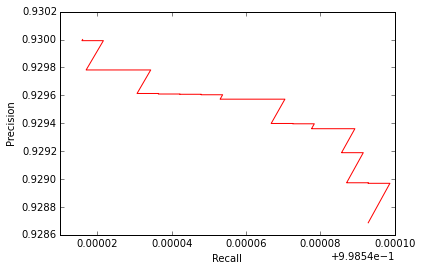

Confusion Matrix : 
[[  37846.     295.]
 [  13013.  193903.]]

Accuracy : 
0.945694267048
Precision of class 1 is : 
0.992265541019
Recall of class 1 is : 
0.744135747852
F-Measure of class 1 is : 
0.850471910112

Precision of class 2 is : 
0.937109745017
Recall of class 2 is : 
0.998480931832
F-Measure of class 2 is : 
0.966822399617



In [106]:
x = perform_GDA(10,'Skin_NonSkin_full.txt','Y',0.93)

#####As seen above, the accuracy has risen to 94.5% after including all the features <br/>Now lets perform GDA on a n Dimensional , k Class Dataset:

###GDA on <font color = 'green'>n Dimensional , k Class </font>Dataset

In [11]:
x = perform_GDA(10,'iris.data','N')

Confusion Matrix : 
[[ 50.   0.   0.]
 [  0.  46.   1.]
 [  0.   4.  49.]]

Accuracy : 
0.966666666667
Precision of class 1 is : 
1.0
Recall of class 1 is : 
1.0
F-Measure of class 1 is : 
1.0

Precision of class 2 is : 
0.978723404255
Recall of class 2 is : 
0.92
F-Measure of class 2 is : 
0.948453608247

Precision of class 3 is : 
0.924528301887
Recall of class 3 is : 
0.98
F-Measure of class 3 is : 
0.95145631068



###Naive Bayes with Bernoulli Features

In [43]:
def beta_c(labels):
    '''Compute and Return prior probabilities for different classes in the dataset'''
    total_examples = len(labels)

    prior_probs = defaultdict(lambda : 0.0)

    for x in labels:
        prior_probs[x[0]] += 1

    for k in prior_probs.keys():
        prior_probs[k] = float(prior_probs[k])/total_examples

    return prior_probs

In [48]:
def alphas(features,labels,e):
    '''Returns the computed alphas dictionary of form alpha[col][class]'''
    cls_and_count = defaultdict(lambda : 0)
    
    for x in labels:
        cls_and_count[x[0]] += 1
    
    alphas = defaultdict(lambda : defaultdict(lambda : 0.0))
    
    total_cols = features.shape[1]
    
    for col_id in range(0,total_cols):
        
        cur_col = features[:,col_id:col_id + 1]
        
        for r_id,value in enumerate(cur_col):
            
            cls_label = labels[r_id][0]
                        
            if value == 1:                                                
                alphas[col_id][cls_label] += 1
            else:
                alphas[col_id][cls_label] #just a default zero initialization
    
    
    for col_id in range(0,total_cols):
        for cls_label in cls_and_count.keys():            
            alphas[col_id][cls_label] = float(alphas[col_id][cls_label] + e) / (cls_and_count[cls_label] + (2*e))
    
    return alphas
    

In [125]:
alphas(tst_features,tst_labels,0.1)

defaultdict(<function <lambda> at 0x000000001A691128>, {0: defaultdict(<function <lambda> at 0x000000001A691198>, {0.0: 0.045454545454545456, 1.0: 0.96875}), 1: defaultdict(<function <lambda> at 0x000000001A691D68>, {0.0: 0.5, 1.0: 0.65625}), 2: defaultdict(<function <lambda> at 0x000000001A6910B8>, {0.0: 0.9545454545454545, 1.0: 0.96875})})

In [49]:
def nb_bern_membership(vec_to_be_pred,alphas,beta_c):
    
    
    prev_mem = -maxint-1
    best_class = -1
    
    for cls in beta_c.keys():
        
        prob_sum = 0
        
        for j in range(0,len(vec_to_be_pred)):
                    
            
            temp1 = vec_to_be_pred[j]* math.log(alphas[j][cls])
            temp2 = (1-vec_to_be_pred[j]) * (math.log(1 - alphas[j][cls]))
            
            prob_sum += (temp1 + temp2) 
        
        prob_sum += math.log(beta_c[cls])
        
        if prob_sum >= prev_mem:
            prev_mem = prob_sum
            best_class = cls
    
    return best_class

In [55]:
#load data matrix
def Bern_NB(file_name,delimiter):
    ''''''
    data_matrix = np.loadtxt(file_name,delimiter=',')

    #segregate features and labels
    features,labels = get_features_labels(data_matrix)
        

    #binarize features
    binarizer = Binarizer(threshold=0.0)
    bin_features = binarizer.transform(features)

    betas = beta_c(labels)

    alpha_scores = alphas(bin_features,labels,1)

    pred_cls_lst = []
    
    for vec in bin_features:
        pred_cls_lst.append(nb_bern_membership(vec,alpha_scores,betas))
    
    #confusion matrix
    ls_lbls = []

    for lbl in labels:
        ls_lbls.append(lbl[0])

    distinct_lbls = len(set(ls_lbls))
    
    conf_matrix = np.zeros((distinct_lbls,distinct_lbls))
    
    for _id,actual in enumerate(labels):
        actual = int(actual)
        pred = int(pred_cls_lst[_id])
        
        conf_matrix[pred-1,actual-1] += 1
    
    perf_measures = evaluate_performance(conf_matrix)
    
    print 'Confusion Matrix : \n' + str(conf_matrix) + '\n'
    print 'Accuracy : ' + '\n' + str(perf_measures['acc'])
    
    #Precision,Recall and F-Measure :
    for cls in perf_measures['rec'].keys():
        print 'Precision of class '+ str(cls) + ' is : \n' + str(perf_measures['prec'][cls])
        print 'Recall of class '+ str(cls) + ' is : \n' + str(perf_measures['rec'][cls])
        print 'F-Measure of class '+ str(cls) + ' is : \n' + str(perf_measures['F-Measure'][cls])
        print ''    
    

In [56]:
Bern_NB('spambase.data',',')

Confusion Matrix : 
[[ 1478.   190.]
 [  335.  2598.]]

Accuracy : 
0.885894370789
Precision of class 1 is : 
0.886091127098
Recall of class 1 is : 
0.815223386652
F-Measure of class 1 is : 
0.84918126975

Precision of class 2 is : 
0.885782475281
Recall of class 2 is : 
0.931850789096
F-Measure of class 2 is : 
0.908232826429



<h3> Let's Compare the accuracy with sklearn's BernoulliNB package</h3>

In [206]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score
from sklearn.utils import column_or_1d

def sk_Bern_NB_accuracy(file_name):
    data_matrix = np.loadtxt(file_name,delimiter=',')

    #segregate features and labels
    features,labels = get_features_labels(data_matrix)

    #binarize features
    binarizer = Binarizer(threshold=0.0)
    bin_features = binarizer.transform(features)


    clf = BernoulliNB()
    
    clf.fit(bin_features, column_or_1d(labels, warn=False))

    pred_ls = []
    for vec in features:
        pred_ls.append(clf.predict(vec))

    ls_lbls = []

    for lbl in labels:
        ls_lbls.append(lbl[0])

    pred_ls_lbls = []

    for lbl in pred_ls:
        pred_ls_lbls.append(lbl[0])

    return accuracy_score(ls_lbls, pred_ls_lbls)

In [207]:
sk_Bern_NB_accuracy('spambase.data')

0.88589437078895894

<h4> In both cases, accuracy is found to be 88.5. Hence Verified. <br><br> The accuracy was so less i.e 88.58 % because, the features in the SPAM dataset were binarized during Bernoulli NB. </h4>

###Naive Bayes with Binomial Features

In [80]:
def alpha_binomial(features,doc_and_len,labels,e):
    
    class_and_sum = defaultdict(lambda : 0)
    
    for k,v in doc_and_len.items():
        lbls = labels[k][0]
        class_and_sum[lbls] += v
    
    
    alphas = defaultdict(lambda : defaultdict(lambda : 0.0))
    
    total_cols = features.shape[1]
    
    for col_id in range(0,total_cols):
        
        cur_col = features[:,col_id:col_id + 1]
        
        for r_id,value in enumerate(cur_col):
            
            cls_label = labels[r_id][0]
            
            alphas[col_id][cls_label] += value
            '''
            if value == 1:                                                
                alphas[col_id][cls_label] += value
            else:
                alphas[col_id][cls_label] #just a default zero initialization
            '''
    
   
    for col_id in range(0,total_cols):
        for cls_label in class_and_sum.keys():            
            alphas[col_id][cls_label] = float(alphas[col_id][cls_label] + e) / (class_and_sum[cls_label] + (2*e))
    
    return alphas
    
    

In [99]:
def nb_binomial_membership(vec_to_be_pred,alphas,beta_c):
    
    
    prev_mem = -maxint-1
    best_class = -1
    
    for cls in beta_c.keys():
        
        prob_sum = 0
        
        for j in range(0,len(vec_to_be_pred)):
            
            p = sum(vec_to_be_pred)
            xj = vec_to_be_pred[j]
            
            temp1 = comb(p,xj)
            temp2 = math.pow(alphas[j][cls],xj)
            temp3 = math.pow(1 - alphas[j][cls],(p-xj))
            

            part1 = math.log(temp1) +math.log(temp2)  +math.log(temp3)
            
            prob_sum += part1
        
        prob_sum += math.log(beta_c[cls])
        
        if prob_sum >= prev_mem:
            prev_mem = prob_sum
            best_class = cls
    
    return best_class

In [110]:
#randomly assign a doc_len
def Binomial(data_set):
    data_matrix = np.loadtxt(data_set,delimiter=',')

    features,labels = get_features_labels(data_matrix)

    #Extract first 48 features
    features = features[:,:48]

    doc_and_len = defaultdict(int)

    for r_id,vec in enumerate(features):

        doc_len = 10
        doc_and_len[r_id] = doc_len

        for c_id,cell in enumerate(vec):            
            features[r_id,c_id] = int(cell * doc_len) 

    #Prior class probs
    betas = beta_c(labels)


    #start
    alpha_scores = alpha_binomial(features,doc_and_len,labels,1)

    pred_cls_lst = []
    for vec in features:
        pred_cls_lst.append(nb_binomial_membership(vec,alpha_scores,betas))

    #confusion matrix
    ls_lbls = []

    for lbl in labels:
        ls_lbls.append(lbl[0])

    distinct_lbls = len(set(ls_lbls))

    conf_matrix = np.zeros((distinct_lbls,distinct_lbls))

    for _id,actual in enumerate(labels):
        actual = int(actual)
        pred = int(pred_cls_lst[_id])

        conf_matrix[pred-1,actual-1] += 1

    perf_measures = evaluate_performance(conf_matrix)

    print 'Confusion Matrix : \n' + str(conf_matrix) + '\n'
    print 'Accuracy : ' + '\n' + str(perf_measures['acc'])

    #Precision,Recall and F-Measure :
    for cls in perf_measures['rec'].keys():
        print 'Precision of class '+ str(cls) + ' is : \n' + str(perf_measures['prec'][cls])
        print 'Recall of class '+ str(cls) + ' is : \n' + str(perf_measures['rec'][cls])
        print 'F-Measure of class '+ str(cls) + ' is : \n' + str(perf_measures['F-Measure'][cls])
        print '' 

In [111]:
Binomial('spambase.data')

Confusion Matrix : 
[[ 1736.  2182.]
 [   77.   606.]]

Accuracy : 
0.509019778309
Precision of class 1 is : 
0.443083205717
Recall of class 1 is : 
0.957528957529
F-Measure of class 1 is : 
0.605827953237

Precision of class 2 is : 
0.887262079063
Recall of class 2 is : 
0.217360114778
F-Measure of class 2 is : 
0.349178910977

